# Language Model Fine Tuning

In this notebook we will fine tune our language model from notebook 01 using the Eduge dataset. 

## Library Installs and Imports

We will need several libraries to get started. Each should be installed and upgraded to ensure it works. This notebook was created in February 2020 and should work with the following major verisons:

- Fast.ai version 2.x
- Fastcore version: 1.x
- Pandas version: 1.x
- Numpy version: 1.x

In [ ]:
!pip install -Uqq torchtext==0.8.0
!pip install -Uqq fastai
!pip install -Uqq fastcore
!pip install -Uqq pandas==1.1.0

     |████████████████████████████████| 7.0MB 12.9MB/s 
     |████████████████████████████████| 194kB 13.3MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 12.8MB 51.8MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
     |████████████████████████████████| 10.5MB 11.9MB/s 


In [ ]:
import fastai
import fastcore
print('Fast.ai version:', fastai.__version__)
print('Fastcore version:', fastcore.__version__)

Fast.ai version: 2.2.7
Fastcore version: 1.3.19


In [ ]:
from fastai.text.all import *
from fastai.callback.progress import CSVLogger
import pandas as pd
import numpy as np
print('Pandas version:', pd.__version__)
print('numpy version:', np.__version__)

Pandas version: 1.1.5
numpy version: 1.19.5


In [ ]:
!pip install -Uqq sentencepiece!=0.1.90,!=0.1.91

     |████████████████████████████████| 1.2MB 14.3MB/s 


We will be using Google Drive to store our files. Please change the directory for the `cd` command to wherever your notebook is located. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/DataScience/NLP/02_mongolian_language_model'

/content/drive/MyDrive/DataScience/NLP/02_mongolian_language_model


In [ ]:
!nvidia-smi

Wed Mar 17 02:50:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    25W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DataScience/NLP/01_eduge_classification/data/news.csv')

In [ ]:
df = df.rename(columns={'news':'text'})

In [ ]:
np.random.seed(42)

In [ ]:
df['is_valid'] = np.random.choice([0,1], size=len(df), p=[0.9, 0.1])

In [ ]:
df.head(2)

,text,label,is_valid
0,"Киноны кадраас «Юрийн галавын үе» кино прокатад тавигдсныхаа дараах эхний амралтын өдрөөр хамгийн их орлого оллоо гэж Business Insider хэвлэл мэдээлэв. Хойд Америкт л гэхэд эхний амралтын өдрүүдэд 204,6 сая доллар цуглуулж чадлаа. Гадаад орнуудын үзүүлэлт нь 307,2 сая ам.доллар байв. Нийт кассын орлого 511,8 сая ам.доллар болжээ. Энэхүү үзүүлэлт нь Universal кино компанийн дээд амжилт төдийгүй дэлхийн кино аж үйлдвэрийн томоохон үсрэлт боллоо. Үүнээс өмнө амралтын эхний өдрүүдэд 500 сая долларын босго давсан их мөнгө цуглуулж байсан түүх байхгүй. «Гарри Поттер ба үхлийн тахил: II хэсэг» 48...",урлаг соёл,0
1,"“Universal” кино компани Жадд Апатоугийн найруулж, “Lonely Island” гэдэг хошин шогийн хамтлагийнхны гол дүрүүдэд нь тоглож байгаа киног 2016 оны зургадугаар сарын 3-нд дэлгэцнээ гаргахаар төлөвлөсөн тухай The Hollywood Reporter мэдээлж байна. Шинэ киноны нэрийг одоохондоо өгөөгүй гэнэ. Кинонд инээдмийн жүжигчид Энди Сэмберг, Йорма Таккоме, Акива Шаффер нар тогложээ. Сүүлийн жилүүдэд гарч ирсэн баримтат киноны элэглэл нь шинэ кино болох ёстой. Энд Жастин Бибер, Кэти Перри нарын элэглэл хамгийн түрүүнд дүрслэгдэх аж. “Lonely Island” хошин шогийн хамтлагийнхан “Saturday Night Live” гэдэгт нэв...",урлаг соёл,1


## Fine Tune Language Model

In [ ]:
bs = 128

In [ ]:
tok = SentencePieceTokenizer(lang='mn', cache_dir='models/spm/ft')

In [ ]:
dblocks = DataBlock(blocks=(TextBlock.from_df('text', is_lm=True, tok=tok)),
                    get_x=ColReader('text'), 
                    splitter=ColSplitter())
dls = dblocks.dataloaders(df, bs=bs, seq_len=80)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
lm_fns = ['mn_20_news_lm', 'mn_20_news_vocab']

In [ ]:
learn = language_model_learner(dls, AWD_LSTM, drop_mult=0.5, pretrained=True, pretrained_fnames=lm_fns, 
                               metrics=[accuracy, Perplexity()]).to_fp16()

In [ ]:
notebook_path = Path('').absolute()
learn.path = notebook_path

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.010964781977236271)

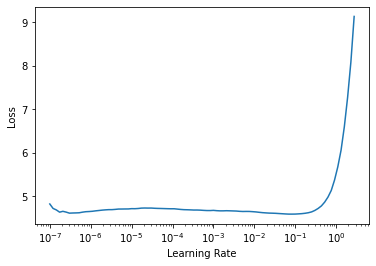

In [ ]:
learn.lr_find()

In [ ]:
lr = 0.01

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.810660,3.584750,0.350774,36.044342,13:25


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, slice(lr/100,lr), moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.702116,3.590430,0.349136,36.249668,13:54
1,3.757325,3.638327,0.343870,38.028156,14:01
2,3.777882,3.615235,0.347706,37.160080,14:00


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.702116,3.590430,0.349136,36.249668,13:54
1,3.757325,3.638327,0.343870,38.028156,14:01
2,3.777882,3.615235,0.347706,37.160080,14:00
3,3.676799,3.580410,0.352337,35.888233,14:02
4,3.638739,3.544666,0.357002,34.628128,14:07
5,3.582995,3.508099,0.361818,33.384731,14:02
6,3.530478,3.472282,0.366177,32.210167,14:08
7,3.562514,3.441010,0.370308,31.218458,14:05
8,3.450880,3.425056,0.372934,30.724379,14:16
9,3.475866,3.421872,0.373488,30.626684,14:11


### Export Fine Tuned Model, Decoder, and Vocab

In [ ]:
learn.to_fp32().save('mn_20_news_lm_ft', with_opt=False)

Path('/content/drive/My Drive/DataScience/NLP/02_mongolian_language_model/models/mn_20_news_lm_ft.pth')

In [ ]:
with open('models/mn_20_news_vocab_ft.pkl', 'wb') as f:
      pickle.dump(learn.dls.vocab, f)

In [ ]:
learn.save_encoder('mn_20_news_encoder_ft')